In [180]:
# make some fake data
import pandas as pd
import numpy as np
from seriesmodel import SeriesModel
from featurizer import PolynomialFeaturizer
from timeseriesplotter import SpotTimePlot
import matplotlib.pyplot as plt
from itertools import izip
%matplotlib inline
from math_capstone import pade, my_sigmoid, my_sigmoid_prime, my_sigmoid_prime_prime
from featurizer import DerivativeFeaturizer

In [181]:
#  Create dummy classes that are just lines and should be easily seperable.
NOISE = 0.05
# sinusoid
def f1(t):
    x = np.sin(t) + NOISE*np.random.randn((len(t)))
    return x

# polynomial
def f2(t):
    x = 3*t**2 - 2*t + 1 + NOISE*np.random.randn((len(t)))
    return x

# sigmoid
def f3(t):
    x = my_sigmoid(t, B=-5) + 0.05*NOISE*np.random.randn((len(t)))
    return x

# EXACT DERIVATIVES AND SECOND DERIVATIVES
def f1p(t):
    x = np.cos(t)
    return x
def f1pp(t):
    x = - np.sin(t)
    return x
def f2p(t):
    x = 6*t - 2
    return x
def f2pp(t):
    x = 6*np.ones(t.shape)
    return x

def f3p(t):
    x = my_sigmoid_prime(t, B=-5)
    return x

def f3pp(t):
    x = my_sigmoid_prime_prime(t, B=-5)
    return x

def add_t1(df, t):
    data = np.hstack((t.reshape(-1,1), f1(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'1', 'gram':'1', 'detection':1}, ignore_index=True)
def add_t2(df, t):
    data = np.hstack((t.reshape(-1,1), f2(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'2', 'gram':'1', 'detection':1}, ignore_index=True)
def add_t3(df, t):
    data = np.hstack((t.reshape(-1,1), f3(t).reshape(-1,1), f3(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'Control', 'gram':'Control', 'detection':0}, ignore_index=True)
def add_t4(df, t):
    data = np.hstack((t.reshape(-1,1), f2(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'3', 'gram':'2', 'detection':1}, ignore_index=True)
def add_t5(df, t):
    data = np.hstack((t.reshape(-1,1), f3(t).reshape(-1,1), f3(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'4', 'gram':'2', 'detection':1}, ignore_index=True)
    


In [182]:
df = pd.DataFrame(columns=['data','classification', 'gram', 'detection'])
t = np.arange(0,25,1)
for i in range(0,10):
    df = add_t1(df,t)
    df = add_t2(df,t)
    df = add_t3(df,t)
for i in range(0,5):
    df = add_t4(df,t)
for i in range(0,8):
    df = add_t5(df,t)
df.head()

,data,classification,gram,detection
0,"[[0.0, 0.00568240601284, 1.01866227352], [1.0,...",1,1,1
1,"[[0.0, 1.00010926877, 1.00513710113], [1.0, 1....",2,1,1
2,"[[0.0, 0.0112431782337, 0.00299058291323], [1....",Control,Control,0
3,"[[0.0, -0.0208100124111, 0.922392229054], [1.0...",1,1,1
4,"[[0.0, 1.04579785027, 1.00896413892], [1.0, 2....",2,1,1


In [183]:
deriv = DerivativeFeaturizer(order=1, dx=1, reference_time=2)
deriv2 = DerivativeFeaturizer(order=2, dx=1, reference_time=2)
X = df['data']
Xp, triggerp = deriv.fit_transform(X)
Xpp, triggerpp = deriv2.fit_transform(X)

Regressed 43 trials in 0 seconds
Regressed 43 trials in 0 seconds


In [184]:
triggerp.iloc[0][0]

3.0

In [185]:
X.iloc[0]

array([[  0.00000000e+00,   5.68240601e-03,   1.01866227e+00],
       [  1.00000000e+00,   8.38996638e-01,   2.01703089e+00],
       [  2.00000000e+00,   9.47803277e-01,   9.07808096e+00],
       [  3.00000000e+00,   1.22765166e-01,   2.20374801e+01],
       [  4.00000000e+00,  -8.19265875e-01,   4.10249112e+01],
       [  5.00000000e+00,  -1.02173576e+00,   6.59227183e+01],
       [  6.00000000e+00,  -2.64757494e-01,   9.70200723e+01],
       [  7.00000000e+00,   6.54426878e-01,   1.33902462e+02],
       [  8.00000000e+00,   9.30913780e-01,   1.76958190e+02],
       [  9.00000000e+00,   4.50031255e-01,   2.25996979e+02],
       [  1.00000000e+01,  -6.56331743e-01,   2.80960306e+02],
       [  1.10000000e+01,  -1.00713185e+00,   3.41962923e+02],
       [  1.20000000e+01,  -5.03558552e-01,   4.09012660e+02],
       [  1.30000000e+01,   3.95652261e-01,   4.82060042e+02],
       [  1.40000000e+01,   1.05619710e+00,   5.60958723e+02],
       [  1.50000000e+01,   6.92142274e-01,   6.4602377

In [186]:
def plot_derivs(t, 
                C, Cp, Cpp, 
                f, fp, fpp, 
                trigger1, trigger2,
                title='myplot'):
    x2 = f(t)
    # sp exact
    y2 = fp(t)
    # sp approx
#     y3, s = pade(x2, 0.1)
    # spp exact
    z2 = fpp(t)
    # spp approx
#     z3, s = pade(y3, 0.1)

    x3, y3, z3 = C, Cp, Cpp

    

#     t2 = t[np.argmax(np.abs(y3))]
#     t3 = t[np.argmax(np.abs(z3))]
    t2 = trigger1
    t3 = trigger2

    print title, t2, t3
#     print x2.shape, y3.shape
    plt.figure(figsize=(12,6))
    plt.plot(t,x2,'b', linewidth=10, alpha=0.5, label='sexact')
    plt.plot(t,x3, 'bo-', label='s')
    plt.plot(t,y2, 'r', linewidth=10, alpha=0.5, label='sp exact')
    plt.plot(t,y3, 'ro-', label='sp pade')
    plt.plot(t,z2, 'g', linewidth=10, alpha=0.5, label='spp exact')
    plt.plot(t,z3, 'go-', label='spp pade')
    plt.axvline(t2, color='purple', label='sp max')
    plt.axvline(t3, color= 'brown', label='spp max', linewidth=3)
    plt.legend()
    plt.title(title)

sin 3.0 24.0
3t2-2t+1 24.0 0.0
sigmoid 5.0 6.0


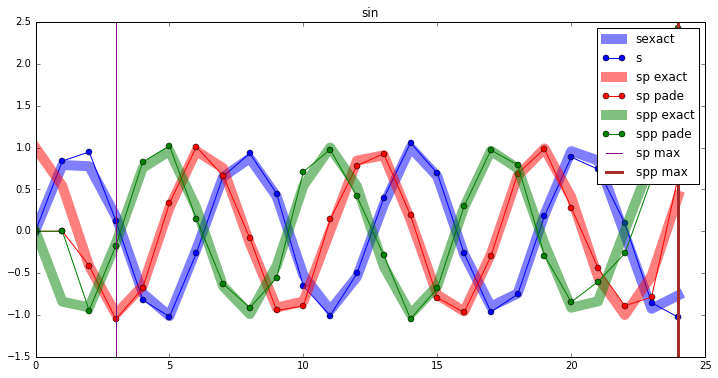

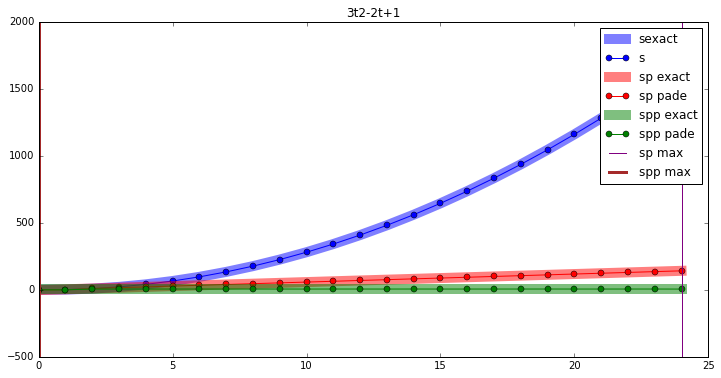

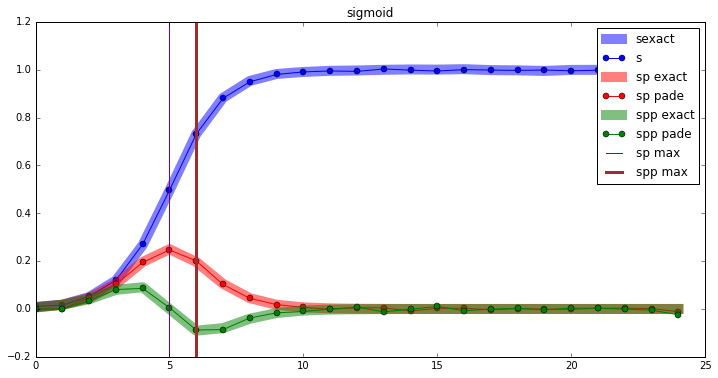

In [187]:
# C = X.iloc[0]
# Cp = Xp.iloc[0]
# Cpp = Xpp.iloc[0]

# f, fp, fpp = f1, f1p, f1pp

plot_derivs(t, 
            X.iloc[0][:,1], Xp.iloc[0][:,0], Xpp.iloc[0][:,0], 
            f1, f1p, f1pp, 
            triggerp.iloc[0][0], triggerpp.iloc[0][0],
            title='sin')
plot_derivs(t, 
            X.iloc[1][:,1], Xp.iloc[1][:,0], Xpp.iloc[1][:,0], 
            f2, f2p, f2pp, 
            triggerp.iloc[1][0], triggerpp.iloc[1][0],
            title='3t2-2t+1')
plot_derivs(t, 
            X.iloc[2][:,1], Xp.iloc[2][:,0], Xpp.iloc[2][:,0], 
            f3, f3p, f3pp, 
            triggerp.iloc[2][0], triggerpp.iloc[2][0],
            title='sigmoid')
# plot_derivs(t, X.iloc[1][:,1], Xp.iloc[1][:,0], Xpp.iloc[1][:,0], f2, f2p, f2pp, title='3t2-2t+1')
# plot_derivs(t, X.iloc[2][:,1], Xp.iloc[2][:,0], Xpp.iloc[2][:,0], f3, f3p, f3pp, title='sigmoid')